### traffic.csv(전국 교통사고 데이터)를 사용해 10개의 문제를 만드시오

In [36]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row, functions , types
from pyspark.sql.functions import when, udf, col, regexp_replace
from pyspark.sql.types import  DoubleType, IntegerType, StringType
import pandas as pd

In [5]:
sc = SparkContext('local')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/22 16:37:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/22 16:38:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
sqlCtx = SQLContext(sc)

/home/mobile/spark-3.3.1-bin-hadoop2/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [9]:
trafDF = sqlCtx.read.csv('data/traffic.csv', encoding='cp949', header=True, inferSchema=True)
trafDF.show()

22/12/22 16:39:09 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+------+------------+------+----+----+--------+--------+--------+--------+------------+----------+------------+---------------+---------------+----------+---------------+--------------------+---------------+----------------+------------------------+-----------------+------------------------+-----------------+--------------+--------------+-----------+-----------+
|발생년|발생년월일시|발생분|주야|요일|사망자수|사상자수|중상자수|경상자수|부상신고자수|발생지시도|발생지시군구|사고유형_대분류|사고유형_중분류|  사고유형|법규위반_대분류|            법규위반|도로형태_대분류|        도로형태|가해자_당사자종별_대분류|가해자_당사자종별|피해자_당사자종별_대분류|피해자_당사자종별|발생위치X_UTMK|발생위치Y_UTMK|       경도|       위도|
+------+------------+------+----+----+--------+--------+--------+--------+------------+----------+------------+---------------+---------------+----------+---------------+--------------------+---------------+----------------+-----

In [10]:
trafDF.printSchema()

root
 |-- 발생년: integer (nullable = true)
 |-- 발생년월일시: integer (nullable = true)
 |-- 발생분: integer (nullable = true)
 |-- 주야: string (nullable = true)
 |-- 요일: string (nullable = true)
 |-- 사망자수: integer (nullable = true)
 |-- 사상자수: integer (nullable = true)
 |-- 중상자수: integer (nullable = true)
 |-- 경상자수: integer (nullable = true)
 |-- 부상신고자수: integer (nullable = true)
 |-- 발생지시도: string (nullable = true)
 |-- 발생지시군구: string (nullable = true)
 |-- 사고유형_대분류: string (nullable = true)
 |-- 사고유형_중분류: string (nullable = true)
 |-- 사고유형: string (nullable = true)
 |-- 법규위반_대분류: string (nullable = true)
 |-- 법규위반: string (nullable = true)
 |-- 도로형태_대분류: string (nullable = true)
 |-- 도로형태: string (nullable = true)
 |-- 가해자_당사자종별_대분류: string (nullable = true)
 |-- 가해자_당사자종별: string (nullable = true)
 |-- 피해자_당사자종별_대분류: string (nullable = true)
 |-- 피해자_당사자종별: string (nullable = true)
 |-- 발생위치X_UTMK: double (nullable = true)
 |-- 발생위치Y_UTMK: double (nullable = true)
 |-- 경도: double (nullable = tr

In [11]:
#1. 요일별 사망자수, 사상자수를 구하시오
trafDF.groupBy("요일").sum("사상자수", "사망자수").show() 


+----+-------------+-------------+
|요일|sum(사상자수)|sum(사망자수)|
+----+-------------+-------------+
|  목|          841|          540|
|  일|          728|          458|
|  금|          839|          581|
|  수|          791|          546|
|  월|          813|          535|
|  화|          835|          552|
|  토|          849|          569|
+----+-------------+-------------+



In [112]:
#2. 서울시의 구별 사망자와 사상자 수를 구하시오
trafDF.where(trafDF['발생지시도'] == '서울').groupBy("발생지시군구").sum("사상자수", "사망자수").orderBy('발생지시군구').show(29) 

+------------+-------------+-------------+
|발생지시군구|sum(사상자수)|sum(사망자수)|
+------------+-------------+-------------+
|      강남구|           28|           20|
|      강동구|           16|           12|
|      강북구|           21|           13|
|      강서구|           18|           11|
|      관악구|            9|            8|
|      광진구|           17|           10|
|      구로구|           17|           13|
|      금천구|            7|            6|
|      노원구|           17|           14|
|      도봉구|            6|            6|
|    동대문구|           14|           14|
|      동작구|           10|            9|
|      마포구|           12|           11|
|    서대문구|            5|            5|
|      서초구|           35|           18|
|      성동구|           10|            9|
|      성북구|           17|           14|
|      송파구|           60|           27|
|      양천구|           13|           11|
|    영등포구|           30|           22|
|      용산구|           15|           14|
|      은평구|           13|           12|
|      종

In [30]:
#3. 사고유형이 '통행' 관련 도로형태 데이터를 구하시오
trafDF.select('도로형태', '사고유형').filter(col("사고유형").rlike("통행")).show()

+----------------+--------------------+
|        도로형태|            사고유형|
+----------------+--------------------+
|      기타단일로|          보도통행중|
|        교차로내|          차도통행중|
|교차로횡단보도내|          보도통행중|
|      기타단일로|길가장자리구역통행중|
|      기타단일로|          차도통행중|
|      기타단일로|          보도통행중|
|      기타단일로|          차도통행중|
|      기타단일로|          차도통행중|
|      기타단일로|          차도통행중|
|      기타단일로|          보도통행중|
|        교차로내|          보도통행중|
|      기타단일로|          차도통행중|
|          주차장|길가장자리구역통행중|
|            기타|길가장자리구역통행중|
|            기타|          차도통행중|
|            기타|          차도통행중|
|      기타단일로|          차도통행중|
|      교차로부근|          차도통행중|
|      기타단일로|          차도통행중|
|        교차로내|          차도통행중|
+----------------+--------------------+
only showing top 20 rows



In [34]:
#4 부산지역 사망자수, 사상자수 총합을 구하시오
trafDF.where(trafDF['발생지시도'] == '부산').agg({'사망자수':'sum', "사상자수":"sum"}).show() 

+-------------+-------------+
|sum(사망자수)|sum(사상자수)|
+-------------+-------------+
|          123|          188|
+-------------+-------------+



In [43]:
from pyspark.sql.window import Window

mywin = Window.orderBy(functions.desc('사망자수합')) 

In [113]:
#5 부산지역 발생지시군구별 사망자수 순위를 구하시오(단 동율도 처리)
trafDF.where(trafDF['발생지시도'] == '부산').groupBy('발생지시군구').agg(functions.sum('사망자수').alias('사망자수합')).withColumn("사망자순위", functions.dense_rank().over(mywin)).toPandas()
# .orderBy('발생지시군구').withColumn('사망자수 순위', functions.row_number().over(mywin)).show()

22/12/22 18:12:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/22 18:12:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/22 18:12:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/22 18:12:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/22 18:12:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/22 18:12:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/22 1

,발생지시군구,사망자수합,사망자순위
0,부산진구,18,1
1,강서구,15,2
2,사상구,15,2
3,해운대구,12,3
4,남구,9,4
5,기장군,8,5
6,금정구,7,6
7,북구,6,7
8,서구,6,7
9,동래구,6,7


In [114]:
#6. 법규위반별 사건 수 내림차순으로 구하시오
trafDF.groupBy('법규위반').agg(functions.count('법규위반').alias('법규위반별 사건수')).orderBy(functions.desc('법규위반별 사건수')).toPandas()

,법규위반,법규위반별 사건수
0,안전운전 의무 불이행,2523
1,신호위반,288
2,중앙선 침범,260
3,과속,220
4,보행자 보호의무 위반,134
5,안전거리 미확보,65
6,교차로 통행방법 위반,56
7,기타(운전자법규위반),35
8,직진 및 우회전차의 통행방해,26
9,부당한 회전,18


In [57]:
#7. 발생월별 사건 수를 바차트로 그리기
trafDF = trafDF.withColumn('발생월', trafDF['발생년월일시'][5:2].cast( IntegerType()))

+------+
|발생월|
+------+
|     2|
|     9|
|    12|
|     8|
|     7|
|    12|
|     1|
|     5|
|     4|
|     2|
|    11|
|     6|
|     1|
|     2|
|     8|
|     8|
|     3|
|     7|
|     9|
|     1|
+------+
only showing top 20 rows



In [116]:
mondeathDF = trafDF.groupBy('발생월').agg(functions.count('사상자수').alias('발생월별 사상자수')).orderBy('발생월')
mondeathDF.show()

+------+-----------------+
|발생월|발생월별 사상자수|
+------+-----------------+
|     1|              297|
|     2|              267|
|     3|              295|
|     4|              292|
|     5|              290|
|     6|              255|
|     7|              305|
|     8|              348|
|     9|              339|
|    10|              363|
|    11|              292|
|    12|              314|
+------+-----------------+



In [66]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='발생월'>

/home/mobile/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mobile/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mobile/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mobile/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mobile/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figu

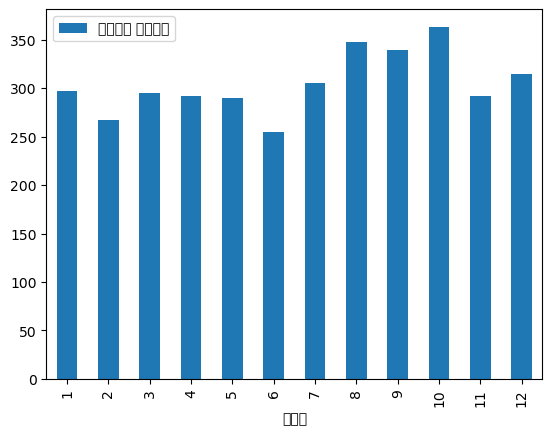

In [67]:
mondeath = mondeathDF.toPandas()
mondeath.plot.bar(x="발생월")

In [117]:
# 8. 피해자가 보행자인 건 수 
trafDF.select('피해자_당사자종별').where(trafDF['피해자_당사자종별'] == '보행자').agg(functions.count('피해자_당사자종별').alias('보행자 피해 건 수')).show()

+-----------------+
|보행자 피해 건 수|
+-----------------+
|             1436|
+-----------------+



In [88]:
#9. 주야별 사상자수, 사망자수
trafDF.select('주야', '사상자수', '사망자수').groupBy('주야').sum().show()

+----+-------------+-------------+
|주야|sum(사상자수)|sum(사망자수)|
+----+-------------+-------------+
|  야|         2682|         1863|
|  주|         3014|         1918|
+----+-------------+-------------+



In [ ]:
#10. 총 피해자(사상, 사망, 중상, 경상, 부상피해) 수


In [108]:
victimDF = trafDF.withColumn("sum", col("사망자수")+col("사상자수")+col("중상자수")+col("경상자수")+col("부상신고자수"))
victimDF.select('sum').show()

+---+
|sum|
+---+
|  2|
|  2|
|  2|
|  2|
|  2|
|  2|
|  2|
|  2|
|  2|
|  2|
|  2|
|  2|
|  2|
|  2|
|  2|
|  2|
|  8|
|  2|
|  2|
|  2|
+---+
only showing top 20 rows



In [109]:
victimDF.agg(functions.sum('sum').alias('총 피해자 수')).show()

+------------+
|총 피해자 수|
+------------+
|       11392|
+------------+

